## 8. EJERCICIO

Vamos a armar una pequeña competición en el curso.
El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST.
Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

*   `test_acc` (del test final)
*   `n_parameter`
*   `n_layers` (conv + activacion + pooling = 1 capa)
*   `n_epochs` de entrenamiento usadas.


El modelo se deberá ajustar a los siguientes parámetros:

*   train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
*   capa final de salida será una softmax de 10 elementos.
*   coss_function será `CrossEntropyLoss`.

El ganador de la competencia será aquel que consiga el mayor `score` empleando la siguietne fórmula:

$$ score = \frac{1}{log_{10}(n\_parameter)} * \frac{10}{n\_epochs}*test\_acc*n\_layers$$

Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).

Es una competencia fairplay y con fines didácticos, esta formula del ```score``` fué inventada.... no usar como referencia para definir qué modelo utilizar.







#### Importar lo necesario

In [1]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
# import pandas
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(17)


#### configuramos el `device` acorde al device disponible




In [108]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

1. Cargar base de datos

In [58]:
x_train = pickle.load( open( "train.pkl", "rb" ) )
y_train =  pickle.load( open( "train_label.pkl", "rb" ) )
x_val =  pickle.load( open( "val.pkl", "rb" ) )
y_val =  pickle.load( open( "val_label.pkl", "rb" ) )
x_test =  pickle.load( open( "test.pkl", "rb" ) )
y_test =  pickle.load( open( "test_label.pkl", "rb" ) )


mean = np.mean(x_train)
print('mean: {}'.format(mean))
std = np.std(x_train)
print('std: {}'.format(std))

x_train = torch.from_numpy(x_train).unsqueeze(1)
x_val = torch.from_numpy(x_val).unsqueeze(1)
x_test = torch.from_numpy(x_test).unsqueeze(1)

y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)


transforms = torchvision.transforms.Compose([
    # torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean,std)
])

x_train_norm = transforms(x_train.float())
x_val_norm = transforms(x_val.float())
x_test_norm = transforms(x_test.float())

print(np.shape(x_train_norm))
print(np.shape(x_train_norm))


train_set = TensorDataset(x_train_norm,y_train)
val_set = TensorDataset(x_val_norm,y_val)
test_set = TensorDataset(x_test_norm,y_test)

dataloader = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, pin_memory=True)
}

mean: 33.32154206905977
std: 78.57221140308602
torch.Size([56000, 1, 28, 28])
torch.Size([56000, 1, 28, 28])


2. Ver que la base de datos esté OK

torch.Size([64, 1, 28, 28])
torch.Size([64])


Text(0.5, 1.0, 'label: 5')

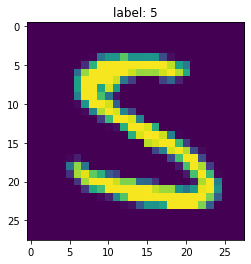

In [79]:
x_train,y_train=next(iter(dataloader['train']))

print(np.shape(x_train))
print(np.shape(y_train))
# print(np.shape(x_val))
# print(np.shape(y_val))
# print(np.shape(x_test))
# print(np.shape(y_test))

k=0
plt.figure()
plt.imshow(x_train[k].squeeze(0))
plt.title('label: {}'.format(y_train[k]))


3. Construyo mi CNN

In [180]:
def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 16)
    self.conv1_out = None
    self.conv2 = block(16, 32)
    self.conv2_out = None
    self.conv3 = block(32, 32)
    self.conv3_out = None
    #self.conv4 = block(128, 128)
    #self.conv4_out = None
    self.fc = torch.nn.Linear(1568, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)

    # x = self.conv3(x)
    # print("Tamaño salida conv3: ", x.shape)

    # x = self.conv4(x)
    # print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    # self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv2_out.view(self.conv2_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

...

In [181]:
model = CNN()
model.validar_dim()


Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  29738
Validacion de dimensiones
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 16, 14, 14])
Tamaño salida conv2:  torch.Size([1, 32, 7, 7])
Ta

...

In [182]:
from tqdm import tqdm # <- para graficar la barra de avance


def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

# score final

In [186]:
n_epochs = 1
i=0
for layer in model.children():
    i=i+1
n_layers = i
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)


model.to(device)
fit(model, dataloader, epochs= n_epochs)

val_loss 0.11011 val_acc 0.96690: 100%|██████████| 110/110 [00:00<00:00, 275.74it/s]

Epoch 1/1 loss 0.15438 val_loss 0.11011 acc 0.95511 val_acc 0.96690


In [184]:
x_test,y_test=next(iter(dataloader['test']))



$$ score = \frac{1}{log_{10}(n\_parameter)} * \frac{10}{n\_epochs}*test\_acc*n\_layers$$

In [185]:
model.to(device)
y_hat = model(x_test.cuda())
test_acc = (y_test.cuda() == torch.argmax(y_hat, axis=1)).sum().item() / len(y_test.cuda())
print(test_acc)
score = 10*test_acc *n_layers /(np.log10(n_parameters) * n_epochs )
print(score)

0.953125
10.653460475710911
